# 矩阵乘法

在cuda c++中实现矩阵乘法（General Matrix Multiplication， GEMM）很容易，通过每一个线程在线程层级的索引，找到应该处理的A矩阵的行和B矩阵的列进行相乘求和，最后再写回C矩阵即可。下面就是最原始的 GEMM 实现方法。

## gemm 数学定义与问题设定

计算 $C = A \times B + C$。
假设矩阵维度：
*   $A$: $M \times K$
*   $B$: $K \times N$
*   $C$: $M \times N$

在 CPU 上，这是一个三层循环：
```cpp
for (int i = 0; i < M; ++i)
    for (int j = 0; j < N; ++j)
        for (int k = 0; k < K; ++k)
            C[i][j] += A[i][k] * B[k][j];
```

## 实现

### naive v1

**核心思想**：GPU 拥有成千上万个线程。让**每个线程负责计算 C 矩阵中的一个元素**。

*   **Grid (网格)** 覆盖整个 $M \times N$ 的区域。
*   **Block (线程块)** 大小通常设为 $16 \times 16$。

每一个线程会根据自己在线程层级的位置，去加载A中对应的一行，B中对应的一列来计算：
```cpp
for(int i = 0; i < N; i++){
    acc += A[row * N + i] * B[i * K + col];
}
```

In [3]:
%%writefile naive_v1.cu
#include <cuda_runtime.h>
#include <stdio.h>

__global__ void matrix_multiplication_kernel(const float* A, const float* B, float* C, int M, int N, int K) {
    int row =  blockDim.y * blockIdx.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    
    if(col >= K || row >= M){
        return;
    }
    
    float acc = 0.0f;
    for(int i = 0; i < N; i++){
        acc += A[row * N + i] * B[i * K + col];
    }
    C[row * K + col] = acc; 
}

// 宿主端 wrapper 函数
extern "C" void solve(const float* A, const float* B, float* C, int M, int N, int K) {
    dim3 threadsPerBlock(16, 16);
    dim3 blocksPerGrid((K + threadsPerBlock.x - 1) / threadsPerBlock.x,
                       (M + threadsPerBlock.y - 1) / threadsPerBlock.y);
    
    matrix_multiplication_kernel<<<blocksPerGrid, threadsPerBlock>>>(A, B, C, M, N, K);
    
    // 检查是否有错误发生
    cudaError_t err = cudaGetLastError();
    if (err != cudaSuccess) {
        printf("CUDA Error: %s\n", cudaGetErrorString(err));
    }
    cudaDeviceSynchronize();
}

Writing naive_v1.cu


### share v2

1. 使用共享内存
   *  现状：在每一个线程里面，为了计算C里面的一个位置上面的值，需要去全局内存上访问N次数据A，也需要访问N次数据B，导致数据等待时间大大增加。
   *  解决：使用线程块里面的共享内存，在一个线程块里面，先读取A和B的一部分数据到线程块里面的共享内存里面，然后进行计算，接着读取下一部分。通过把全局内存分块到共享内存上避免所有线程去读取全局内存里面的数据，这样只需要读取一次全局内存，剩下线程块里面的线程只需要去共享内存上面进行访问即可。

In [4]:
%%writefile shared_v2.cu
#include <stdio.h>
#include <cuda_runtime.h>
#define TILE_WIDTH 32

__global__ void matrix_multiplication_shared_mem(const float* __restrict__ A, const float* __restrict__ B, float* C, int M, int N, int K) {

    __shared__ float As[TILE_WIDTH][TILE_WIDTH];
    __shared__ float Bs[TILE_WIDTH][TILE_WIDTH];

    int bx = blockIdx.x;
    int by = blockIdx.y;
    int tx = threadIdx.x;
    int ty = threadIdx.y;

    int row = by * TILE_WIDTH + ty;
    int col = bx * TILE_WIDTH + tx;

    float acc = 0.0f;

    // 循环遍历所有的 Tile
    for (int t = 0; t < (N + TILE_WIDTH - 1) / TILE_WIDTH; ++t) {

        if (row < M && t * TILE_WIDTH + tx < N) {
            As[ty][tx] = A[row * N + t * TILE_WIDTH + tx];
        } else {
            As[ty][tx] = 0.0f;
        }
        if (col < K && t * TILE_WIDTH + ty < N) {
            // 注意这里 B 的索引：行是 t*TILE_WIDTH + ty, 列是 col
            Bs[ty][tx] = B[(t * TILE_WIDTH + ty) * K + col];
        } else {
            Bs[ty][tx] = 0.0f;
        }
        __syncthreads();
        for (int i = 0; i < TILE_WIDTH; ++i) {
            acc += As[ty][i] * Bs[i][tx];
        }

        __syncthreads();
    }

    if (row < M && col < K) {
        C[row * K + col] = acc;
    }
}

extern "C" void solve(const float* A, const float* B, float* C, int M, int N, int K) {
    dim3 threadsPerBlock(TILE_WIDTH, TILE_WIDTH);
    dim3 blocksPerGrid((K + threadsPerBlock.x - 1) / threadsPerBlock.x,
                       (M + threadsPerBlock.y - 1) / threadsPerBlock.y);
    
    matrix_multiplication_shared_mem<<<blocksPerGrid, threadsPerBlock>>>(A, B, C, M, N, K);
    
    cudaError_t err = cudaGetLastError();
    if (err != cudaSuccess) {
        printf("CUDA Error: %s\n", cudaGetErrorString(err));
    }
    
    cudaDeviceSynchronize();
}

Writing shared_v2.cu


### vector load & thread coarsening v3

1. 向量化加载（vector load）
    *   问题： 每次线程在从全局内存上面加载数据到共享内存时，或者在共享内存上面加载数据到寄存器时，通常只加载一个float数据，通常是4个字节。虽然有访存合并，但是一次加载和存放的数据太小了。
    *   解决：让一个线程一次性读取多个数据元素，将其视为一个向量进行传输。CUDA 为此提供了内置的向量数据类型，如 `int2`, `int4`, `float2`, `float4`, `double2` 等。

2. 线程粗化（thread coarsening）
    * 问题：


In [5]:
%%writefile vl_tc_v3.cu
#include <stdio.h>
#include <cuda_runtime.h>

// 宏定义块大小
// TS (Tile Size): 每个 Block 计算 64x64 的 C
// WPT (Work Per Thread): 每个线程计算 4x4 的 C
// TS_K: K 维度(你的代码里是 N 维度)的分块大小，设为 8 或 16
#define TS 64
#define WPT 4
#define TS_K 16 

// 优化后的 Kernel
__global__ void matrix_multiplication_optimized(
    const float* __restrict__ A, 
    const float* __restrict__ B, 
    float* __restrict__ C, 
    int M, int N, int K) 
{
    // 每个 Block 处理 C 中 TS x TS (64x64) 的区域
    // 线程块维度: dim3(TS/WPT, TS/WPT) -> (16, 16) -> 256 个线程
    
    // 1. 声明共享内存
    // As: 存储 A 的切片 [TS][TS_K] -> [64][16]
    // Bs: 存储 B 的切片 [TS_K][TS] -> [16][64]
    __shared__ float As[TS][TS_K];
    __shared__ float Bs[TS_K][TS];

    // 2. 声明寄存器
    // accum: 累加器，每个线程负责计算 4x4 = 16 个元素
    float accum[WPT][WPT] = {0.0f};
    
    // reg_A, reg_B: 用于在内循环中缓存从 SMEM 读取的值
    float reg_A[WPT];
    float reg_B[WPT];

    // 线程 ID 和 Block ID
    int tx = threadIdx.x; // range 0-15
    int ty = threadIdx.y; // range 0-15
    int bx = blockIdx.x;
    int by = blockIdx.y;

    // 当前线程负责的 C 矩阵起始坐标 (C 的分块左上角 + 线程偏移)
    // 每个线程覆盖 WPT(4) 个像素宽/高
    int row_c = by * TS + ty * WPT; 
    int col_c = bx * TS + tx * WPT;

    // 3. 循环遍历 N 维度 (步长 TS_K = 16)
    for (int t = 0; t < N; t += TS_K) {
        
        // --- 加载数据到 Shared Memory (协作加载) ---
        // 我们有 256 个线程。
        // 需要加载 A 的 Tile: 64行 * 16列 = 1024 元素。每个线程加载 1024/256 = 4 个元素。
        // 需要加载 B 的 Tile: 16行 * 64列 = 1024 元素。每个线程加载 4 个元素。
        
        // 加载 As (A 的子块): 
        // 这里的逻辑是将 256 个线程映射到 64x16 的区域
        // 我们使用 float4 向量化加载来极致优化带宽
        
        // 计算当前线程加载 As 的位置
        // 将 16x16 的线程块视为 256 个线性线程
        int tid = ty * (TS / WPT) + tx; // 0 ~ 255
        
        // 映射到 As[64][16]: 每一行 16 个元素，如果是 float4 就是 4 个 float4
        // 256 个线程，每个加载 1 个 float4 (4个float)，正好 1024 个 float
        // As 的行索引
        int load_a_row = tid / (TS_K / 4); 
        int load_a_col = (tid % (TS_K / 4)) * 4;
        
        // 从全局内存 A 加载到 As
        // 全局索引: A[(by * TS + load_a_row) * N + (t + load_a_col)]
        // 注意边界检查省略了，假设维度对其
        if (by * TS + load_a_row < M && t + load_a_col < N) {
             // 使用 float4 指针强转进行向量加载
             float4 tmp = reinterpret_cast<const float4*>(&A[(by * TS + load_a_row) * N + (t + load_a_col)])[0];
             As[load_a_row][load_a_col + 0] = tmp.x;
             As[load_a_row][load_a_col + 1] = tmp.y;
             As[load_a_row][load_a_col + 2] = tmp.z;
             As[load_a_row][load_a_col + 3] = tmp.w;
        }

        // 加载 Bs (B 的子块): [16][64]
        // 同样用 tid 映射。每行 64 个元素 = 16 个 float4。
        // 总共 16 行。总 float4 数 = 16 * 16 = 256。正好每个线程取 1 个 float4。
        int load_b_row = tid / (TS / 4);
        int load_b_col = (tid % (TS / 4)) * 4;

        if (t + load_b_row < N && bx * TS + load_b_col < K) {
             float4 tmp = reinterpret_cast<const float4*>(&B[(t + load_b_row) * K + (bx * TS + load_b_col)])[0];
             Bs[load_b_row][load_b_col + 0] = tmp.x;
             Bs[load_b_row][load_b_col + 1] = tmp.y;
             Bs[load_b_row][load_b_col + 2] = tmp.z;
             Bs[load_b_row][load_b_col + 3] = tmp.w;
        }

        __syncthreads(); // 等待数据加载完成

        // --- 在寄存器上进行计算 ---
        // 遍历 Shared Memory 中的 TS_K (16) 维度
        #pragma unroll
        for (int k = 0; k < TS_K; ++k) {
            
            // 1. 将所需的 As 和 Bs 数据预加载到寄存器
            // 每个线程计算 4x4，需要 As 的一列 4 个值，Bs 的一行 4 个值
            for (int i = 0; i < WPT; ++i) {
                reg_A[i] = As[ty * WPT + i][k];
                reg_B[i] = Bs[k][tx * WPT + i];
            }

            // 2. 外积计算 (Outer Product)
            // 计算 4x4 的结果，复用 reg_A 和 reg_B
            for (int row = 0; row < WPT; ++row) {
                for (int col = 0; col < WPT; ++col) {
                    accum[row][col] += reg_A[row] * reg_B[col];
                }
            }
        }
        
        __syncthreads(); // 等待计算完成，准备加载下一块
    }

    // 4. 写回结果到全局内存
    // 每个线程写回 4x4 个点
    for (int row = 0; row < WPT; ++row) {
        for (int col = 0; col < WPT; ++col) {
            int global_row = row_c + row;
            int global_col = col_c + col;
            
            if (global_row < M && global_col < K) {
                C[global_row * K + global_col] = accum[row][col];
            }
        }
    }
}

// Host 端调用示例
extern "C" void solve(const float* d_A, const float* d_B, float* d_C, int M, int N, int K) {
    // 线程块大小: 16x16 = 256 线程
    dim3 threadsPerBlock(TS / WPT, TS / WPT); 
    
    // Grid 大小: 因为每个 Block 处理 64x64，所以除以 TS(64)
    dim3 numBlocks((K + TS - 1) / TS, (M + TS - 1) / TS);

    matrix_multiplication_optimized<<<numBlocks, threadsPerBlock>>>(d_A, d_B, d_C, M, N, K);
}

Writing vl_tc_v3.cu


### scale v3_1

v3 的最大问题就是1个线程只处理 4*4 个输出数据，没有充分利用线程上面的寄存器和shared memory，因此可以让一个线程处理更多的数据。下面这个版本一个线程可以处理`8*8`个数据

In [6]:
%%writefile vl_tc_v3_1.cu
#include <stdio.h>
#include <cuda_runtime.h>

// 宏定义块大小
// TS (Tile Size): 每个 Block 计算 128x128 的 C
// WPT (Work Per Thread): 每个线程计算 8x8 的 C
// TS_K: 共享内存中的分块大小
#define TS 128
#define WPT 8
#define TS_K 16 

__global__ void matrix_multiplication_optimized(
    const float* __restrict__ A, 
    const float* __restrict__ B, 
    float* __restrict__ C, 
    int M, int N, int K) 
{
    __shared__ float As[TS][TS_K];
    __shared__ float Bs[TS_K][TS];

    float accum[WPT][WPT] = {0.0f};
    
    float reg_A[WPT];
    float reg_B[WPT];

    int tx = threadIdx.x;
    int ty = threadIdx.y;
    int bx = blockIdx.x;
    int by = blockIdx.y;
    
    // 当前线程负责的 C 矩阵起始坐标 (C 的分块左上角 + 线程偏移)
    int row_c = by * TS + ty * WPT; 
    int col_c = bx * TS + tx * WPT;

    for (int t = 0; t < N; t += TS_K) {
        
        int tid = ty * (TS / WPT) + tx;
        
        int load_a_row = tid / (TS_K / WPT); 
        int load_a_col = (tid % (TS_K / WPT)) * WPT;
        
        if (by * TS + load_a_row < M && t + load_a_col < N) {
             // 使用 float4 指针强转进行向量加载
             // 1. 计算内存中的基础偏移量 (base index)
            int base_offset = (by * TS + load_a_row) * N + (t + load_a_col);

            // 2. 将指针强转为 float4* 并读取两个连续的 float4
            // A[base_offset] 是起点
            const float4* A_ptr = reinterpret_cast<const float4*>(&A[base_offset]);

            float4 tmp1 = A_ptr[0]; // 加载第 0-15 字节 (float 0-3)
            float4 tmp2 = A_ptr[1]; // 加载第 16-31 字节 (float 4-7)

            // 3. 将数据写入共享内存 As
            // 优化：同样使用 float4 向量化写入共享内存，比逐个 float 赋值更快
            float4* As_ptr = reinterpret_cast<float4*>(&As[load_a_row][load_a_col]);

            As_ptr[0] = tmp1; // 写入 As[row][col + 0~3]
            As_ptr[1] = tmp2; // 写入 As[row][col + 4~7]
        }

        // 加载 Bs (B 的子块): [16][64]
        // 同样用 tid 映射。每行 64 个元素 = 16 个 float4。
        // 总共 16 行。总 float4 数 = 16 * 16 = 256。正好每个线程取 1 个 float4。
        int load_b_row = tid / (TS / WPT);
        int load_b_col = (tid % (TS / WPT)) * WPT;

        if (t + load_b_row < N && bx * TS + load_b_col < K) {
            // 使用 float4 指针强转进行向量加载
            // 1. 计算内存中的基础偏移量 (base index)
            int base_offset = (t + load_b_row) * K + (bx * TS + load_b_col);

            // 2. 将指针强转为 float4* 并读取两个连续的 float4
            // A[base_offset] 是起点
            const float4* B_ptr = reinterpret_cast<const float4*>(&B[base_offset]);

            float4 tmp1 = B_ptr[0]; // 加载第 0-15 字节 (float 0-3)
            float4 tmp2 = B_ptr[1]; // 加载第 16-31 字节 (float 4-7)

            // 3. 将数据写入共享内存 As
            // 优化：同样使用 float4 向量化写入共享内存，比逐个 float 赋值更快
            float4* Bs_ptr = reinterpret_cast<float4*>(&Bs[load_b_row][load_b_col]);

            Bs_ptr[0] = tmp1; // 写入 As[row][col + 0~3]
            Bs_ptr[1] = tmp2; // 写入 As[row][col + 4~7]
        }

        __syncthreads(); // 等待数据加载完成

        // --- 在寄存器上进行计算 ---
        // 遍历 Shared Memory 中的 TS_K (16) 维度
        #pragma unroll
        for (int k = 0; k < TS_K; ++k) {
            
            // 1. 将所需的 As 和 Bs 数据预加载到寄存器
            // 每个线程计算 4x4，需要 As 的一列 4 个值，Bs 的一行 4 个值
            for (int i = 0; i < WPT; ++i) {
                reg_A[i] = As[ty * WPT + i][k];
                reg_B[i] = Bs[k][tx * WPT + i];
            }

            // 2. 外积计算 (Outer Product)
            // 计算 4x4 的结果，复用 reg_A 和 reg_B
            for (int row = 0; row < WPT; ++row) {
                for (int col = 0; col < WPT; ++col) {
                    accum[row][col] += reg_A[row] * reg_B[col];
                }
            }
        }
        
        __syncthreads(); // 等待计算完成，准备加载下一块
    }

    // 4. 写回结果到全局内存
    // 每个线程写回 4x4 个点
    for (int row = 0; row < WPT; ++row) {
        for (int col = 0; col < WPT; ++col) {
            int global_row = row_c + row;
            int global_col = col_c + col;
            
            if (global_row < M && global_col < K) {
                C[global_row * K + global_col] = accum[row][col];
            }
        }
    }
}

// Host 端调用示例
extern "C" void solve(const float* d_A, const float* d_B, float* d_C, int M, int N, int K) {
    // 线程块大小: 16x16 = 256 线程
    dim3 threadsPerBlock(TS / WPT, TS / WPT); 
    
    // Grid 大小: 因为每个 Block 处理 64x64，所以除以 TS(64)
    dim3 numBlocks((K + TS - 1) / TS, (M + TS - 1) / TS);

    matrix_multiplication_optimized<<<numBlocks, threadsPerBlock>>>(d_A, d_B, d_C, M, N, K);
}

Writing vl_tc_v3_1.cu


### prefetch & vector back v4

v3_3的版本还可以继续优化：

1.  **数据预取**：
    *   **现状**：v3_3的代码逻辑是 `Load -> Sync -> Compute -> Sync`。在 `Compute` 期间，内存总线是空闲的；在 `Load` 期间，计算单元（ALU）是空闲的。
    *   **优化**：使用两个 Shared Memory 缓冲区。当 GPU 正在计算当前块（Tile $k$）时，同时将下一个块（Tile $k+1$）从 Global Memory 加载到寄存器，并在计算间隙写入另一个 Shared Memory 缓冲区。这可以掩盖内存延迟。引入了 __shared__ ... [2][...]。在主循环中，并没有直接从 Global Memory 写入 Shared Memory，而是先加载到 ldg_a_reg (Local Registers)。
  
    流水线：
    1. Load Next Tile (Global -> Register)
    2. Compute Current Tile (Shared -> Register -> ALU)
    2. __syncthreads()
    2. Store Next Tile (Register -> Shared)
    2. __syncthreads()
    
    这种写法允许 GPU 在做乘加运算（耗时最长）的同时，利用内存控制器去抓取下一个块的数据。

2.  **向量化回写 Global Memory**：
    *   **现状**：最后写入 `C` 时使用了双重循环逐个 `float` 写入。
    *   **优化**：同样使用 `float4` 指针转换，将计算结果向量化写回 Global Memory，提高写入带宽利用率。

3.  **索引计算简化**：
    *   **现状**：代码中的索引计算（如 `tid / (TS_K / WPT)`）涉及较多整数除法和取模，这些指令在 GPU 上比加减法慢。
    *   **优化**：可以通过预计算或位运算优化。使用 `<` 和 `>` 等位运算来代替乘除法。

In [7]:
%%writefile pre_vb_v4.cu
#include <stdio.h>
#include <cuda_runtime.h>

// 宏定义块大小
#define TS 128      // Tile Size M, N
#define TS_K 16     // Tile Size K
#define WPT 8       // Work Per Thread

__global__ void matrix_multiplication_double_buffer(
    const float* __restrict__ A, 
    const float* __restrict__ B, 
    float* __restrict__ C, 
    int M, int N, int K) 
{
    // Double Buffering: 申请 2 倍的 Shared Memory
    // [2] 代表两个缓冲区：buffer_curr 和 buffer_next
    __shared__ float As[2][TS][TS_K];
    __shared__ float Bs[2][TS_K][TS];

    // 寄存器累加器
    float accum[WPT][WPT] = {0.0f};
    
    // 用于计算的寄存器片段
    float reg_A[WPT];
    float reg_B[WPT];

    // 用于预取 Global Memory 数据的寄存器
    // 每个线程负责加载 8 个 float (2个 float4)
    float ldg_a_reg[2][4]; // [2个float4][每个包含4个float]
    float ldg_b_reg[2][4];

    int tx = threadIdx.x;
    int ty = threadIdx.y;
    int bx = blockIdx.x;
    int by = blockIdx.y;
    
    // 在线程块中取出这个线程的索引， TS/WPT 表示一行有多少个线程（写回的字节块宽度/每一个线程处理的字节数）
    int tid = ty * (TS / WPT) + tx; // 0 ~ 255

    // --- 1. 预计算加载索引 ---
    // 线程负责加载 A 的位置: A_tile 是 128x16
    // 每个线程加载 8 个元素。总共 256 线程 * 8 = 2048 元素 = 128*16。
    // A 的行索引 (0-127) 和 列索引 (0, 8)
    int load_a_row = tid >> 1; // tid / 2
    int load_a_col = (tid & 1) << 3; // (tid % 2) * 8

    // 线程负责加载 B 的位置: B_tile 是 16x128
    // B 的行索引 (0-15) 和 列索引 (0-120，步长8)
    int load_b_row = tid >> 4; // tid / 16
    int load_b_col = (tid & 15) << 3; // (tid % 16) * 8

    // A 和 B 在 Global Memory 中的基础指针（调整到当前 Block 的行/列起点）
    // 注意：这里假设 A是(M, N/K_dim)，B是(N/K_dim, K/N_width)。
    // 根据用户代码逻辑：
    // A: [M][N_arg], B: [N_arg][K_arg] (这里 N_arg 对应 K 维度)
    // 使用题目中的变量名：
    // A 的行偏移由 by 决定，B 的列偏移由 bx 决定
    const float* A_ptr_base = A + (by * TS + load_a_row) * N; 
    const float* B_ptr_base = B + load_b_row * K + (bx * TS + load_b_col);

    // --- 2. Prologue: 加载第一个 Tile 到寄存器，然后放入 SMEM ---
    
    // 边界检查并加载 A
    {
        // 这里的 t=0，对应 A 的列偏移 load_a_col
        bool row_valid = (by * TS + load_a_row < M);
        // 使用 float4 加载
        const float4* A_vec_ptr = reinterpret_cast<const float4*>(A_ptr_base + load_a_col);
        // 只能在内存安全时读取，否则填 0
        float4 tmp1 = (row_valid && (load_a_col < N)) ? A_vec_ptr[0] : make_float4(0.0f, 0.0f, 0.0f, 0.0f);
        float4 tmp2 = (row_valid && (load_a_col + 4 < N)) ? A_vec_ptr[1] : make_float4(0.0f, 0.0f, 0.0f, 0.0f);
        
        // 写入 SMEM buffer 0
        // 手动展开 float4 赋值以匹配 float 数组结构，或者转换指针
        // 这里为了 Padding 对齐安全，建议逐个或 reinterpret_cast 写入
        // As[0][load_a_row][load_a_col + 0..3]
        reinterpret_cast<float4*>(&As[0][load_a_row][load_a_col])[0] = tmp1;
        reinterpret_cast<float4*>(&As[0][load_a_row][load_a_col + 4])[0] = tmp2;
    }

    // 边界检查并加载 B
    {
        int col_B = bx * TS + load_b_col;
        // t=0
        const float4* B_vec_ptr = reinterpret_cast<const float4*>(B_ptr_base); 
        // 注意：B 是 Row-Major，B_ptr_base 是起点。
        // 但这里 B 的 Tile 是随着 K 维度(用户变量 N) 移动的。
        // 实际上 B 的指针移动是：ptr + t * K_width。
        // 原代码逻辑：(t + load_b_row) * K
        
        // 修正指针计算：每次循环 B 向下移，A 向右移
        const float* B_ptr_curr = B + load_b_row * K + col_B;
        
        float4 tmp1 = (load_b_row < N && col_B<K) ? 
                      reinterpret_cast<const float4*>(B_ptr_curr)[0] : make_float4(0.0f,0.0f,0.0f,0.0f);
        float4 tmp2 = (load_b_row < N && (col_B + 4 < K)) ? 
                      reinterpret_cast<const float4*>(B_ptr_curr + 4)[0] : make_float4(0.0f,0.0f,0.0f,0.0f);

        reinterpret_cast<float4*>(&Bs[0][load_b_row][load_b_col])[0] = tmp1;
        reinterpret_cast<float4*>(&Bs[0][load_b_row][load_b_col + 4])[0] = tmp2;
    }

    __syncthreads();

    // --- 3. Main Loop ---
    int write_stage_idx = 1; // 下一次写入的 buffer
    int load_stage_idx = 0;  // 当前计算使用的 buffer

    // t 从 0 开始，每次步进 TS_K
    // 注意：Prologue 已经加载了 t=0 的数据。
    // 循环内主要做：计算(t)，预加载(t+TS_K)
    for (int t = 0; t < N; t += TS_K) {
        
        // === Step 3.1: 预加载 下一个 Tile (t + TS_K) 到 寄存器 ===
        // 这样不会覆盖当前正在被 Compute 读取的 SMEM
        int next_t = t + TS_K;
        
        if (next_t < N) {
            // Load A
            bool row_valid = (by * TS + load_a_row < M);
            // 指针偏移：A 向右移 TS_K
            int load_next_a_col = next_t + load_a_col;
            const float4* A_vec_ptr = reinterpret_cast<const float4*>(A_ptr_base + load_next_a_col);
            
            float4 t1 = (row_valid && (load_next_a_col < N)) ? A_vec_ptr[0] : make_float4(0.0f,0.0f,0.0f,0.0f);
            float4 t2 = (row_valid && (load_next_a_col + 4 < N)) ? A_vec_ptr[1] : make_float4(0.0f,0.0f,0.0f,0.0f);
            
            // 暂存到寄存器
            reinterpret_cast<float4*>(ldg_a_reg)[0] = t1;
            reinterpret_cast<float4*>(ldg_a_reg)[1] = t2;

            // Load B
            int load_next_b_col = bx * TS + load_b_col;
            int load_next_b_row = next_t + load_b_row;
            // 指针偏移：B 向下移 TS_K
            const float* B_ptr_next = B + load_next_b_row * K + load_next_b_col;
            
            float4 t3 = (load_next_b_row < N && load_next_b_col<K) ? 
                        reinterpret_cast<const float4*>(B_ptr_next)[0] : make_float4(0.0f,0.0f,0.0f,0.0f);
            float4 t4 = (load_next_b_row < N && (load_next_b_col + 4 < K)) ? 
                        reinterpret_cast<const float4*>(B_ptr_next + 4)[0] : make_float4(0.0f,0.0f,0.0f,0.0f);
            
            reinterpret_cast<float4*>(ldg_b_reg)[0] = t3;
            reinterpret_cast<float4*>(ldg_b_reg)[1] = t4;
        }

        // === Step 3.2: 计算 当前 Tile (SMEM[load_stage_idx]) ===
        #pragma unroll
        for (int k = 0; k < TS_K; ++k) {
            // 加载 A 的一列 (由当前线程负责的 WPT 行)
            #pragma unroll
            for (int i = 0; i < WPT; ++i) {
                // As 有 Padding，访问安全
                reg_A[i] = As[load_stage_idx][ty * WPT + i][k];
            }
            // 加载 B 的一行 (由当前线程负责的 WPT 列)
            #pragma unroll
            for (int i = 0; i < WPT; ++i) {
                reg_B[i] = Bs[load_stage_idx][k][tx * WPT + i];
            }
            // 外积计算
            #pragma unroll
            for (int row = 0; row < WPT; ++row) {
                #pragma unroll
                for (int col = 0; col < WPT; ++col) {
                    accum[row][col] += reg_A[row] * reg_B[col];
                }
            }
        }

        // === Step 3.3: Store 寄存器 -> SMEM ===
        // 必须先 Sync，确保所有线程都完成了 Compute (读 SMEM)，才能写入下一轮的数据
        __syncthreads();

        if (next_t < N) {
            // 将预加载到寄存器的数据写入 Shared Memory 的另一半
            reinterpret_cast<float4*>(&As[write_stage_idx][load_a_row][load_a_col])[0] = reinterpret_cast<float4*>(ldg_a_reg)[0];
            reinterpret_cast<float4*>(&As[write_stage_idx][load_a_row][load_a_col + 4])[0] = reinterpret_cast<float4*>(ldg_a_reg)[1];

            reinterpret_cast<float4*>(&Bs[write_stage_idx][load_b_row][load_b_col])[0] = reinterpret_cast<float4*>(ldg_b_reg)[0];
            reinterpret_cast<float4*>(&Bs[write_stage_idx][load_b_row][load_b_col + 4])[0] = reinterpret_cast<float4*>(ldg_b_reg)[1];
        }

        // 交换 buffer索引
        load_stage_idx = 1 - load_stage_idx;
        write_stage_idx = 1 - write_stage_idx;

        // 必须再次 Sync，确保 SMEM 写入完成，下一轮 Compute 可以读取
        __syncthreads();
    }

    // --- 4. 写回结果到全局内存 (向量化) ---
    // 每个线程负责 8x8 的块
    // 我们可以每行写两个 float4
    int row_c = by * TS + ty * WPT; 
    int col_c = bx * TS + tx * WPT;

    #pragma unroll
    for (int row = 0; row < WPT; ++row) {
        int global_row = row_c + row;
        if (global_row < M) {
            #pragma unroll
            for (int col_offset = 0; col_offset < WPT; col_offset += 4) {
                int global_col = col_c + col_offset;
                if (global_col < K) { // 简单边界检查，假设 K 是 4 的倍数
                     // 构造 float4
                     float4 res;
                     res.x = accum[row][col_offset + 0];
                     res.y = accum[row][col_offset + 1];
                     res.z = accum[row][col_offset + 2];
                     res.w = accum[row][col_offset + 3];
                     
                     // 写入
                     if (global_col + 4 <= K) {
                        reinterpret_cast<float4*>(&C[global_row * K + global_col])[0] = res;
                     } else {
                        // 边缘处理 (略，假设对其)
                        for(int i=0; i<4; i++) {
                            if(global_col + i < K) C[global_row * K + global_col+i] = ((float*)&res)[i];
                        }
                     }
                }
            }
        }
    }
}

extern "C" void solve(const float* d_A, const float* d_B, float* d_C, int M, int N, int K) {
    dim3 threadsPerBlock(TS / WPT, TS / WPT); 
    dim3 numBlocks((K + TS - 1) / TS, (M + TS - 1) / TS);
    matrix_multiplication_double_buffer<<<numBlocks, threadsPerBlock>>>(d_A, d_B, d_C, M, N, K);
}

Writing pre_vb_v4.cu


### scale v4_1

线程块获取的数据减少

In [8]:
%%writefile pre_vb_v4_1.cu
// 第7个版本
#include <cuda_runtime.h>
#include <stdio.h>

// ==========================================
// T4 优化参数 + 双重缓冲策略
// ==========================================
const int BM = 128;
const int BN = 128;
const int BK = 8;
const int TM = 8;
const int TN = 8;

__global__ __launch_bounds__(256)
void sgemm_double_buffer_t4(
    const float* __restrict__ A, 
    const float* __restrict__ B, 
    float* __restrict__ C, 
    int M, int N, int K) 
{
    int tid = threadIdx.x;
    int ty = tid / 16;
    int tx = tid % 16;
    int by = blockIdx.y;
    int bx = blockIdx.x;
    
    // =========================================================
    // 关键改变 1: 双重缓冲 Shared Memory
    // 使用 [2] 个 buffer，write_stage 用于写，read_stage 用于算
    // =========================================================
    __shared__ float As[2][BK][BM]; 
    __shared__ float Bs[2][BK][BN];

    float accum[TM][TN] = {0.0f};
    
    // 寄存器缓存，用于计算
    float rag[TM];
    float rbg[TN];

    // 寄存器缓存，用于 Global Memory 预取 (Prefetch)
    // 每个线程搬运 1 个 float4 的 A 和 1 个 float4 的 B
    float4 load_a_reg; 
    float4 load_b_reg;

    const float* A_ptr = A + by * BM * K;
    const float* B_ptr = B + bx * BN;

    // 加载索引计算
    int load_a_row = tid / 2; 
    int load_a_col = (tid % 2) * 4;
    int load_b_row = tid / 32;
    int load_b_col = (tid % 32) * 4;

    // =========================================================
    // Prologue (序幕): 加载第一个 Tile 到 Buffer 0
    // =========================================================
    {
        int k_start = 0;
        // Load A
        if (by * BM + load_a_row < M && k_start + load_a_col < K) {
            load_a_reg = reinterpret_cast<const float4*>(&A_ptr[load_a_row * K + k_start + load_a_col])[0];
        } else {
            load_a_reg = {0.0f, 0.0f, 0.0f, 0.0f};
        }
        // Load B
        if (k_start + load_b_row < K && bx * BN + load_b_col < N) {
            load_b_reg = reinterpret_cast<const float4*>(&B_ptr[(k_start + load_b_row) * N + load_b_col])[0];
        } else {
            load_b_reg = {0.0f, 0.0f, 0.0f, 0.0f};
        }

        // 写入 SMEM Buffer 0
        // A 转置写入
        As[0][load_a_col + 0][load_a_row] = load_a_reg.x;
        As[0][load_a_col + 1][load_a_row] = load_a_reg.y;
        As[0][load_a_col + 2][load_a_row] = load_a_reg.z;
        As[0][load_a_col + 3][load_a_row] = load_a_reg.w;
        
        // B 直接写入
        reinterpret_cast<float4*>(&Bs[0][load_b_row][load_b_col])[0] = load_b_reg;
    }

    __syncthreads();

    // =========================================================
    // Main Loop
    // =========================================================
    int write_stage_idx = 1; // 下一轮写入的位置
    int read_stage_idx = 0;  // 当前计算读取的位置

    // 注意：循环从 k=0 开始算，但在 k 时我们要预加载 k+BK 的数据
    for (int k = 0; k < K; k += BK) {
        
        // -----------------------------------------------------
        // 1. Prefetch Next Tile to Registers (Global -> Register)
        // 这里的关键是：当我们发起 Global Load 指令后，GPU 不会阻塞，
        // 而是会继续向下执行计算指令 (Math)，从而隐藏内存延迟。
        // -----------------------------------------------------
        int next_k = k + BK;
        if (next_k < K) {
            // Load A to Reg
            if (by * BM + load_a_row < M && next_k + load_a_col < K) {
                load_a_reg = reinterpret_cast<const float4*>(&A_ptr[load_a_row * K + next_k + load_a_col])[0];
            } else {
                load_a_reg = {0.0f, 0.0f, 0.0f, 0.0f};
            }
            // Load B to Reg
            if (next_k + load_b_row < K && bx * BN + load_b_col < N) {
                load_b_reg = reinterpret_cast<const float4*>(&B_ptr[(next_k + load_b_row) * N + load_b_col])[0];
            } else {
                load_b_reg = {0.0f, 0.0f, 0.0f, 0.0f};
            }
        }

        // -----------------------------------------------------
        // 2. Compute Current Tile (Register <-> SMEM)
        // 使用 read_stage_idx
        // -----------------------------------------------------
        #pragma unroll
        for (int i = 0; i < BK; ++i) {
            // Load A from SMEM to Reg
            float4 tmpA0 = reinterpret_cast<const float4*>(&As[read_stage_idx][i][ty * TM])[0];
            float4 tmpA1 = reinterpret_cast<const float4*>(&As[read_stage_idx][i][ty * TM + 4])[0];
            rag[0] = tmpA0.x; rag[1] = tmpA0.y; rag[2] = tmpA0.z; rag[3] = tmpA0.w;
            rag[4] = tmpA1.x; rag[5] = tmpA1.y; rag[6] = tmpA1.z; rag[7] = tmpA1.w;

            // Load B from SMEM to Reg
            float4 tmpB0 = reinterpret_cast<const float4*>(&Bs[read_stage_idx][i][tx * TN])[0];
            float4 tmpB1 = reinterpret_cast<const float4*>(&Bs[read_stage_idx][i][tx * TN + 4])[0];
            rbg[0] = tmpB0.x; rbg[1] = tmpB0.y; rbg[2] = tmpB0.z; rbg[3] = tmpB0.w;
            rbg[4] = tmpB1.x; rbg[5] = tmpB1.y; rbg[6] = tmpB1.z; rbg[7] = tmpB1.w;

            // Compute
            #pragma unroll
            for (int r = 0; r < TM; ++r) {
                #pragma unroll
                for (int c = 0; c < TN; ++c) {
                    accum[r][c] += rag[r] * rbg[c];
                }
            }
        }

        // -----------------------------------------------------
        // 3. Store Prefetched Data to SMEM (Register -> SMEM)
        // 此时计算已经完成，我们等待所有线程都算完了当前块
        // -----------------------------------------------------
        __syncthreads(); // 确保 read_stage 的数据大家都不用了

        if (next_k < K) {
            // 将寄存器里的下一块数据写入 write_stage 的 SMEM
            // A Transposed
            As[write_stage_idx][load_a_col + 0][load_a_row] = load_a_reg.x;
            As[write_stage_idx][load_a_col + 1][load_a_row] = load_a_reg.y;
            As[write_stage_idx][load_a_col + 2][load_a_row] = load_a_reg.z;
            As[write_stage_idx][load_a_col + 3][load_a_row] = load_a_reg.w;

            // B Direct
            reinterpret_cast<float4*>(&Bs[write_stage_idx][load_b_row][load_b_col])[0] = load_b_reg;
        }

        // 翻转 buffer 索引
        // write_stage: 1 -> 0 -> 1
        // read_stage:  0 -> 1 -> 0
        write_stage_idx ^= 1;
        read_stage_idx ^= 1;

        __syncthreads(); // 确保 write_stage 的数据已经写好，可以作为下一轮的 read_stage
    }

    // =========================================================
    // Write Back
    // =========================================================
    int global_row_start = by * BM + ty * TM;
    int global_col_start = bx * BN + tx * TN;

    #pragma unroll
    for (int r = 0; r < TM; ++r) {
        int global_r = global_row_start + r;
        if (global_r < M) {
            int global_c = global_col_start;
            if (global_c + 7 < N) {
                float4 tmp0, tmp1;
                tmp0.x = accum[r][0]; tmp0.y = accum[r][1]; tmp0.z = accum[r][2]; tmp0.w = accum[r][3];
                tmp1.x = accum[r][4]; tmp1.y = accum[r][5]; tmp1.z = accum[r][6]; tmp1.w = accum[r][7];
                reinterpret_cast<float4*>(&C[global_r * N + global_c])[0] = tmp0;
                reinterpret_cast<float4*>(&C[global_r * N + global_c + 4])[0] = tmp1;
            } else {
                for (int c = 0; c < TN; ++c) {
                    if (global_c + c < N) {
                        C[global_r * N + global_c + c] = accum[r][c];
                    }
                }
            }
        }
    }
}

// 宿主调用
extern "C" void solve(const float* A, const float* B, float* C, int M, int N, int K) {
    dim3 block(256);
    dim3 grid((N + BN - 1) / BN, (M + BM - 1) / BM);
    sgemm_double_buffer_t4<<<grid, block>>>(A, B, C, M, N, K);
}

Writing pre_vb_v4_1.cu


## 编译 cu 文件为共享库 so 文件

In [9]:
import os
import subprocess
for v in os.listdir(os.path.abspath('.')):
    prefix, end = os.path.splitext(v)
    if end == '.cu':
        subprocess.run(f"nvcc -shared -o {prefix}.so {prefix}.cu -Xcompiler -fPIC", shell=True)
print(os.listdir())

pre_vb_v4.cu(85): warning #177-D: variable "B_vec_ptr" was declared but never referenced
          const float4* B_vec_ptr = reinterpret_cast<const float4*>(B_ptr_base);
                        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"



['vl_tc_v3.so', 'shared_v2.cu', 'pre_vb_v4.cu', 'vl_tc_v3_1.cu', 'naive_v1.so', 'shared_v2.so', 'naive_v1.cu', 'pre_vb_v4_1.so', 'pre_vb_v4_1.cu', 'vl_tc_v3_1.so', 'vl_tc_v3.cu', 'pre_vb_v4.so', '.virtual_documents']


## 进行性能测试

已加载内核: naive_v1.so
已加载内核: shared_v2.so
已加载内核: vl_tc_v3.so
已加载内核: vl_tc_v3_1.so
已加载内核: pre_vb_v4.so
已加载内核: pre_vb_v4_1.so

====== 正在测试尺寸: [128x128] * [128x128] ======
PyTorch 	: 0.017 ms | 0.253 TFLOPS
naive_v1 	: 0.040 ms | 0.105 TFLOPS ✅
shared_v2 	: 0.038 ms | 0.110 TFLOPS ✅
vl_tc_v3 	: 0.031 ms | 0.137 TFLOPS ✅
vl_tc_v3_1 	: 0.113 ms | 0.037 TFLOPS ✅
pre_vb_v4 	: 0.084 ms | 0.050 TFLOPS ✅
pre_vb_v4_1 	: 0.084 ms | 0.050 TFLOPS ✅

====== 正在测试尺寸: [512x512] * [512x512] ======
PyTorch 	: 0.132 ms | 2.031 TFLOPS
naive_v1 	: 1.158 ms | 0.232 TFLOPS ✅
shared_v2 	: 0.703 ms | 0.382 TFLOPS ✅
vl_tc_v3 	: 0.220 ms | 1.221 TFLOPS ✅
vl_tc_v3_1 	: 0.327 ms | 0.820 TFLOPS ✅
pre_vb_v4 	: 0.286 ms | 0.938 TFLOPS ✅
pre_vb_v4_1 	: 0.289 ms | 0.929 TFLOPS ✅

====== 正在测试尺寸: [1024x1024] * [1024x1024] ======
PyTorch 	: 0.807 ms | 2.662 TFLOPS
naive_v1 	: 5.508 ms | 0.390 TFLOPS ✅
shared_v2 	: 2.770 ms | 0.775 TFLOPS ✅
vl_tc_v3 	: 0.774 ms | 2.775 TFLOPS ✅
vl_tc_v3_1 	: 0.929 ms | 2.313 TFLOPS ✅
pre_vb_v4 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


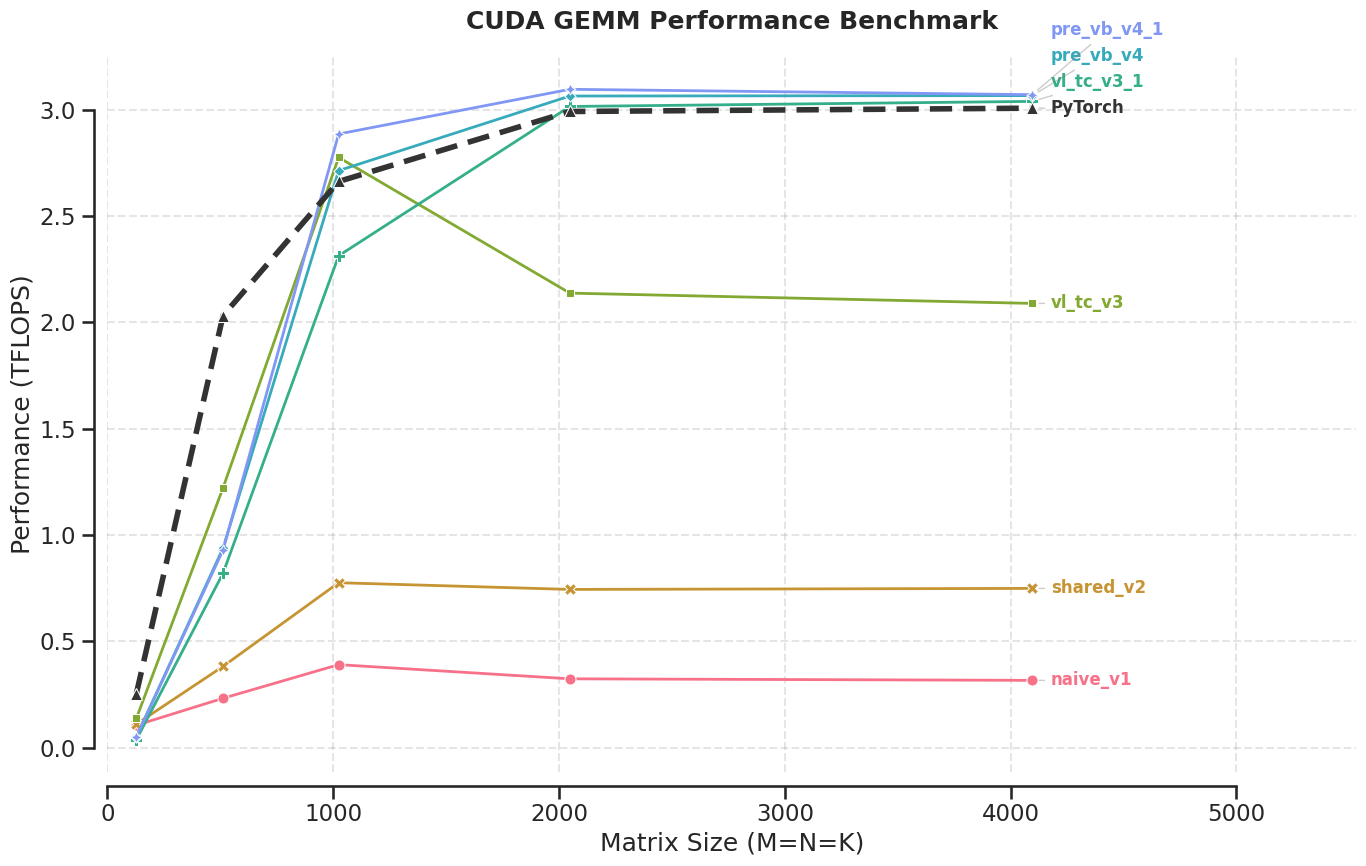

In [23]:
import torch
import ctypes
import numpy as np
import time
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- 配置参数 ---
SIZES = [128, 512, 1024, 2048, 4096] # 测试的矩阵大小
N_WARMUP = 5   # 预热次数
N_ITERS = 40   # 计时的平均运行次数
ATOL = 1e-3    # 结果验证的容差
torch.manual_seed(42)

# --- 辅助函数：自然排序 (v1, v2, v10...) ---
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split('.*v([0-9]+)', s)]

# --- 核心：CUDA 库包装器 ---
class CUDALibWrapper:
    def __init__(self, lib_path):
        self.lib_path = lib_path
        self.name = os.path.splitext(os.path.basename(lib_path))[0]
        self.lib = ctypes.CDLL(lib_path)
        # 配置 solve 函数参数: A_ptr, B_ptr, C_ptr, M, N, K
        self.lib.solve.argtypes = [
            ctypes.c_void_p, ctypes.c_void_p, ctypes.c_void_p,
            ctypes.c_int, ctypes.c_int, ctypes.c_int
        ]

    def __call__(self, a_tensor, b_tensor, c_tensor):
        M, N = a_tensor.shape
        _, K = b_tensor.shape
        self.lib.solve(
            ctypes.c_void_p(a_tensor.data_ptr()),
            ctypes.c_void_p(b_tensor.data_ptr()),
            ctypes.c_void_p(c_tensor.data_ptr()),
            ctypes.c_int(M), ctypes.c_int(N), ctypes.c_int(K)
        )

# --- 核心：基准测试函数 ---
def benchmark_kernel(func, args, n_warmup, n_iters):
    # 预热
    for _ in range(n_warmup):
        func(*args)
    torch.cuda.synchronize()
    
    # 计时
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    
    start_event.record()
    for _ in range(n_iters):
        func(*args)
    end_event.record()
    torch.cuda.synchronize()
    
    # 返回平均耗时 (毫秒)
    return start_event.elapsed_time(end_event) / n_iters

# --- 主程序 ---
def main():
    # 1. 扫描并加载所有 .so 文件
    so_files = [f for f in os.listdir('.') if f.endswith('.so')]
    so_files.sort(key=natural_sort_key)
    
    kernels = []
    for f in so_files:
        try:
            kernels.append(CUDALibWrapper(f"./{f}"))
            print(f"已加载内核: {f}")
        except Exception as e:
            print(f"加载 {f} 失败: {e}")

    # 存储结果: { 'MethodName': [perf_size1, perf_size2, ...] }
    results = {k.name: [] for k in kernels}
    results['PyTorch'] = []
    
    # 2. 循环测试不同大小
    for size in SIZES:
        M, N, K = size, size, size
        print(f"\n====== 正在测试尺寸: [{M}x{N}] * [{N}x{K}] ======")
        
        # 准备数据
        device = torch.device("cuda")
        A = torch.randn(M, N, device=device, dtype=torch.float32)
        B = torch.randn(N, K, device=device, dtype=torch.float32)
        C_ref = torch.matmul(A, B) # PyTorch 结果作为基准
        
        # 计算 FLOPs (2 * M * N * K)
        flops = 2 * M * N * K
        
        # --- 测试 PyTorch ---
        def run_torch(): torch.matmul(A, B)
        avg_ms = benchmark_kernel(run_torch, (), N_WARMUP, N_ITERS)
        tflops = (flops / (avg_ms / 1000)) / 1e12
        results['PyTorch'].append(tflops)
        print(f"PyTorch \t: {avg_ms:.3f} ms | {tflops:.3f} TFLOPS")

        # --- 测试自定义内核 ---
        for kernel in kernels:
            C_custom = torch.zeros((M, K), device=device, dtype=torch.float32)
            
            # 正确性检查
            kernel(A, B, C_custom)
            torch.cuda.synchronize()
            
            if not torch.allclose(C_custom, C_ref, atol=ATOL):
                print(f"{kernel.name} \t: ❌ 结果错误 (Max Diff: {(C_custom - C_ref).abs().max().item():.4f})")
                results[kernel.name].append(0.0) # 错误记为 0 分
                continue
            
            # 性能测试
            def run_custom(): kernel(A, B, C_custom)
            avg_ms = benchmark_kernel(run_custom, (), N_WARMUP, N_ITERS)
            tflops = (flops / (avg_ms / 1000)) / 1e12
            results[kernel.name].append(tflops)
            print(f"{kernel.name} \t: {avg_ms:.3f} ms | {tflops:.3f} TFLOPS ✅")

    # 3. 绘制图表
    plot_results_seaborn(SIZES, results)

def plot_results_seaborn(sizes, results):
    data = []
    for name, perfs in results.items():
        for s, p in zip(sizes, perfs):
            data.append({
                'Matrix Size': s,
                'TFLOPS': p,
                'Method': name
            })
    df = pd.DataFrame(data)
    sns.set_theme(style="ticks", context="talk", font_scale=1.0)
    fig, ax = plt.subplots(figsize=(14, 9))
    methods = df['Method'].unique()
    n_methods = len(methods)
    palette = sns.color_palette("husl", n_methods)
    color_dict = dict(zip(methods, palette))
    dash_dict = {m: (1, 0) for m in methods} # 默认实线
    size_dict = {m: 2.0 for m in methods}    # 默认宽度

    if 'PyTorch' in color_dict:
        color_dict['PyTorch'] = '#333333'
        dash_dict['PyTorch'] = (4, 2)
        size_dict['PyTorch'] = 4.0   

    sns.lineplot(
        data=df,
        x='Matrix Size',
        y='TFLOPS',
        hue='Method',
        style='Method',
        size='Method',
        palette=color_dict,
        dashes=dash_dict,
        sizes=size_dict,
        markers=True, 
        markersize=8,
        ax=ax,
        legend=False
    )

    last_points = []
    for name in methods:
        subset = df[df['Method'] == name]
        last_row = subset.iloc[-1]
        last_points.append({
            'y': last_row['TFLOPS'],
            'x': last_row['Matrix Size'],
            'label': name,
            'color': color_dict[name]
        })
    last_points.sort(key=lambda x: x['y'])
    
    all_y = df['TFLOPS'].values
    y_span = all_y.max() - all_y.min()
    min_dist = y_span * 0.04 
    last_text_y = -float('inf')
    x_max = sizes[-1]
    ax.set_xlim(left=0, right=x_max * 1.35) 

    for point in last_points:
        current_y = point['y']
        text_y = max(current_y, last_text_y + min_dist)
        last_text_y = text_y
        ax.annotate(
            text=point['label'],
            xy=(point['x'], point['y']), 
            xytext=(x_max * 1.02, text_y),
            color=point['color'],
            fontweight='bold',
            fontsize=12,
            va='center',
            arrowprops=dict(
                arrowstyle="-",
                color='gray',
                alpha=0.4,
                lw=1,
                shrinkB=5
            )
        )

    ax.set_title('CUDA GEMM Performance Benchmark', pad=20, fontweight='bold')
    ax.set_xlabel('Matrix Size (M=N=K)')
    ax.set_ylabel('Performance (TFLOPS)')
    ax.grid(True, which="major", ls="--", c='gray', alpha=0.2)
    
    sns.despine(trim=True, offset=10)
    
    plt.tight_layout()
    plt.savefig('gemm_benchmark_seaborn.png', dpi=300, bbox_inches='tight')
    plt.show()

main()